In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns


import pytorch_lightning as pl

sys.path.insert(0, os.path.abspath("python_packages"))
from python_packages import *
from src import *


# Add the Mirai_Risk_Prediction_Model directory to the Python path
sys.path.append('Mirai_Risk_Prediction_Model')
# Also add the current directory to ensure all modules can be found
sys.path.append('.')

In [10]:

n = 200
d1 = 50
d2 = 100
rj = 2
ri1 = 2
ri2 = 1

Scores_J = np.random.normal(loc=0, scale=1, size=(rj, n))
Scores_I1 = np.random.normal(loc=0, scale=1, size=(ri1, n))
Scores_I2 = np.random.normal(loc=0, scale=1, size=(ri2, n))

Loadings_J1 = np.random.normal(loc=0, scale=1, size=(rj, d1))
Loadings_J2 = np.random.normal(loc=0, scale=1, size=(rj, d2))
Loadings_I1 = np.random.normal(loc=0, scale=1, size=(ri1, d1))
Loadings_I2 = np.random.normal(loc=0, scale=1, size=(ri2, d2))

J1 = Scores_J.T @ Loadings_J1
J2 = Scores_J.T @ Loadings_J2
I1 = Scores_I1.T @ Loadings_I1
I2 = Scores_I2.T @ Loadings_I2

B1 = J1 + I1 + np.random.normal(loc=0, scale=0.001, size=(n, d1))
B2 = J2 + I2 + np.random.normal(loc=0, scale=0.001, size=(n, d2))
print(f'B1 shape: {B1.shape}, B2 shape: {B2.shape}')

aj = AJIVE(init_signal_ranks=[4,3], n_jobs=16, center=True)
aj.fit([B1, B2])
aj.summary()

B1 shape: (200, 50), B2 shape: (200, 100)


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0

'AJIVE, joint rank: 2, view 0 indiv rank: 2, view 1 indiv rank: 1'

In [38]:
aj.get_view_decomps()[0]['joint'] == aj.common_.view_scores_[0] @ aj.view_specific_[0].joint_.loadings_.T

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [37]:
aj.common_.view_scores_
aj.view_specific_[0].joint_.loadings_.shape
aj.common_.view_scores_[0] == aj.common_.view_scores_[1]

array([[False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [Fal

In [20]:
# Create additional t-SNE visualizations comparing different feature representations
def create_comprehensive_tsne_comparison(feature_sets, labels, split_to_plot = 'train'):
    """
    Create comprehensive t-SNE comparison across different feature representations
    """    
    # Set up colors
    unique_labels = np.unique(labels)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    class_names = {0: 'BI-RADS 1', 1: 'BI-RADS 2', 2: 'BI-RADS 3', 3: 'BI-RADS 4', 4: 'BI-RADS 5'}
    
    # Calculate optimal subplot layout
    n_features = len(feature_sets)
    n_cols = 3  # Fixed 3 columns for better layout
    n_rows = int(np.ceil(n_features / n_cols))
    
    # Create subplots with proper layout
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    
    # Flatten axes array for easy indexing (handles both 1D and 2D cases)
    if n_rows == 1:
        axes = axes if n_cols > 1 else [axes]  # Handle single row case
    else:
        axes = axes.flatten()  # Flatten 2D array to 1D
    
    for idx, (feature_name, features_train, features_val, features_test) in enumerate(feature_sets):
        print(f"Computing t-SNE for {feature_name}...")
        if split_to_plot == 'train':
            features = features_train
        elif split_to_plot == 'val':
            features = features_val
        elif split_to_plot == 'test':
            features = features_test
        else:
            raise ValueError("split_to_plot must be 'train', 'val', or 'test'")
        
        # Compute t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
        features_tsne = tsne.fit_transform(features)
        
        # Plot on the correct axis
        ax = axes[idx]
        for i, label in enumerate(unique_labels):
            mask = labels == label
            ax.scatter(features_tsne[mask, 0], features_tsne[mask, 1], 
                      c=[colors[i]], label=f'{class_names.get(label, f"Class {label}")}',
                      alpha=0.7, s=15)
        
        ax.set_title(f't-SNE: {feature_name}\n({features.shape[1]} dimensions)', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('t-SNE Component 1')
        ax.set_ylabel('t-SNE Component 2')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide any unused subplots
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()   

def evaluate_svm_classifier(X_train, y_train, X_val, y_val, X_test, y_test, feature_name):
    """
    Train and evaluate an RBF SVM classifier with comprehensive metrics
    """
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Train RBF SVM
    svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
    #svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
    svm_classifier.fit(X_train_scaled, y_train)
    
    # Make predictions
    test_pred = svm_classifier.predict(X_test_scaled)
    
    # Calculate comprehensive metrics
    test_acc_macro = balanced_accuracy_score(y_test, test_pred)  # Overall accuracy
    test_f1_macro = f1_score(y_test, test_pred, average='macro')
    test_f1_weighted = f1_score(y_test, test_pred, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    
    
    results = {
        'feature_name': feature_name,
        'feature_dims': X_train.shape[1],
        'test_acc_macro': test_acc_macro,
        'test_f1_macro': test_f1_macro,
        'test_f1_weighted': test_f1_weighted,
        'confusion_matrix': cm,
        'test_predictions': test_pred,
        'test_labels': y_test
    }
    
    return results, svm_classifier
    
def compare_feature_transformations_svm_clean(feature_sets, label_sets):
    """
    Clean version with execution tracking to prevent duplicate display
    """
    
    # Store results
    all_results = []
    
    print("Comparing Feature Transformations with RBF SVM...")
    print("=" * 70)
    
    for i, (feature_name, X_train, X_val, X_test) in enumerate(feature_sets):
        print(f"\n[{i+1}/{len(feature_sets)}] 🔍 {feature_name}")
        print(f"Dimensions: {X_train.shape[1]}")
        print("-" * 50)
        
        try:
            results, trained_svm = evaluate_svm_classifier(
                X_train, label_sets[0],
                X_val, label_sets[1],
                X_test, label_sets[2],
                feature_name
            )
            all_results.append(results)
            
            print(f" Accuracy: {results['test_acc_macro']:.4f} | F1: {results['test_f1_macro']:.4f}")
            
        except Exception as e:
            print(f" ERROR: {str(e)}")
    
    print(f"\n Execution completed: {len(all_results)} evaluations")
    return all_results


def plot_confusion_matrices_comparison(all_results):
    """
    Create a comprehensive confusion matrix comparison plot
    """
    n_methods = len(all_results)
    
    # Create figure with subplots
    fig, axes = plt.subplots(int(np.ceil(n_methods / 3)), 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Get unique class labels
    all_labels = set()
    for result in all_results:
        all_labels.update(result['test_labels'])
        all_labels.update(result['test_predictions'])
    class_labels = sorted(list(all_labels))
    
    for idx, result in enumerate(all_results):
        ax = axes[idx]
        
        # Plot confusion matrix
        cm = result['confusion_matrix']
        im = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                        xticklabels=class_labels, yticklabels=class_labels)
        
        # Add title with metrics
        title = f"{result['feature_name']}\n"
        title += f"Macro Acc: {result['test_acc_macro']:.3f}, "
        title += f"Macro F1: {result['test_f1_macro']:.3f}\n"
        title += f"Dims: {result['feature_dims']}"
        
        ax.set_title(title, fontsize=11, pad=20)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
    
    # Remove empty subplots if any
    for idx in range(n_methods, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    return fig
    

In [2]:
from Mirai_Risk_Prediction_Model.asymmetry_model.mirai_localized_dif_head import extract_mirai_backbone

In [3]:
encoder = extract_mirai_backbone('Mirai_Risk_Prediction_Model/asymmetry_model/mgh_mammo_MIRAI_Base_May20_2019.p')

In [3]:
breast_loader = Breast_Cancer_Dataloader(
    root_folder='/Users/jazav7774/Data/Mammo/',
    annotation_csv="modified_breast-level_annotations.csv",
    imagefolder_path="images_png_396",
    image_format="png",
    norm_kind="dataset_zscore",
    batch_size=32,  
    num_workers=1,
    task=1,
    use_train_sampler=False,            # Disable weighted sampling for feature extraction - true train dataset
)

model = Two_view_model.load_from_checkpoint('artifacts/model-9a0gw17z:v0/model.ckpt')
model_dens = Two_view_model.load_from_checkpoint('artifacts/model-8hidkyff:v0/model.ckpt')

In [4]:
def get_featurized_data(dataloader, model, model1):
    """
    Get the full featurized dataset from a dataloader.
    """
    model.to('mps')
    model.eval()
    model1.to('mps')
    model1.eval()
    with torch.no_grad():
        all_in_features = []
        all_in_features1 = []

        all_labels = []
        all_labels1 = []

        for batch in tqdm.tqdm(dataloader, desc="Featurizing dataset"):
            x, y1, y2 = batch
            #y = y1 if model.task == 1 else y2
            x = [item.to('mps') for item in x]
            y1 = y1.to('mps')
            y2 = y2.to('mps')
            all_labels.append(y1)
            all_labels1.append(y2)
            
            x2 = [model.resnets[i](image) for i, image in enumerate(x)]
            
            x4 = [model1.resnets[i](image) for i, image in enumerate(x)]

            all_in_features.append(torch.cat(x2, dim=1))
            
            all_in_features1.append(torch.cat(x4, dim=1))
            
        all_in_features = torch.cat(all_in_features, dim=0)
        all_in_features1 = torch.cat(all_in_features1, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        all_labels1 = torch.cat(all_labels1, dim=0)

    return all_in_features, all_labels, all_in_features1, all_labels1

In [5]:
def process_and_save_all_splits(breast_loader, model, model_dens, save_dir='saved_features'):
    """
    Process train, testidation, and test dataloaders and save features and labels.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    splits = {
        'train': breast_loader.train_dataloader(),
        'val': breast_loader.val_dataloader(),
        'test': breast_loader.test_dataloader()
    }
    
    for split_name, dataloader in splits.items():
        print(f"Processing {split_name} split...")
        
        cancer_features, cancer_labels, dens_features, dens_labels = get_featurized_data(
            dataloader, model, model_dens
        )
        
        # Move to CPU before saving
        cancer_features = cancer_features.cpu()
        cancer_labels = cancer_labels.cpu()
        dens_features = dens_features.cpu()
        dens_labels = dens_labels.cpu()
        
        # Also save as dictionary for convenience
        torch.save({
            'cancer_features': cancer_features,
            'cancer_labels': cancer_labels,
            'dens_features': dens_features,
            'dens_labels': dens_labels
        }, f'{save_dir}/all_data_{split_name}.pt')
        
        print(f"Saved {split_name} split with shapes:")
        print(f"  Cancer features: {cancer_features.shape}")
        print(f"  Cancer labels: {cancer_labels.shape}")
        print(f"  Density features: {dens_features.shape}")
        print(f"  Density labels: {dens_labels.shape}")
        print()

# Run the processing and saving


In [ ]:
#process_and_save_all_splits(breast_loader, model, model_dens, save_dir='saved_features/CANCvsDENS/')

Processing train split...


Featurizing dataset: 100%|██████████| 200/200 [06:11<00:00,  1.86s/it]


Saved train split with shapes:
  Cancer features: torch.Size([6400, 256])
  Cancer labels: torch.Size([6400])
  Density features: torch.Size([6400, 256])
  Density labels: torch.Size([6400])

Processing val split...


Featurizing dataset: 100%|██████████| 50/50 [01:50<00:00,  2.21s/it]


Saved val split with shapes:
  Cancer features: torch.Size([1598, 256])
  Cancer labels: torch.Size([1598])
  Density features: torch.Size([1598, 256])
  Density labels: torch.Size([1598])

Processing test split...


Featurizing dataset: 100%|██████████| 63/63 [02:11<00:00,  2.09s/it]


Saved test split with shapes:
  Cancer features: torch.Size([2000, 256])
  Cancer labels: torch.Size([2000])
  Density features: torch.Size([2000, 256])
  Density labels: torch.Size([2000])



In [4]:
train_data = torch.load('saved_features/CANCvsDENS/all_data_train.pt')
train_cancer_features = train_data['cancer_features'].numpy()
train_cancer_labels = train_data['cancer_labels'].numpy()
train_dens_features = train_data['dens_features'].numpy()
train_dens_labels = train_data['dens_labels'].numpy()

In [14]:
train_cancer_features.shape

(6400, 256)

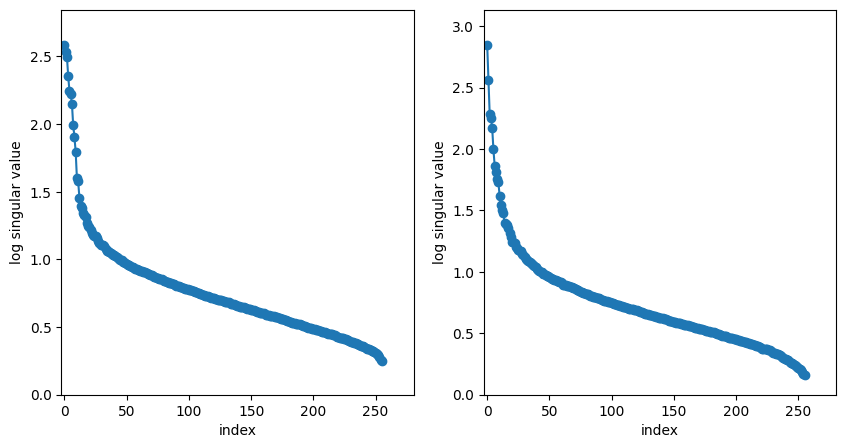

In [5]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
PCA().fit(train_cancer_features).plot_scree(log = True)
plt.subplot(1, 2, 2)
PCA().fit(train_dens_features).plot_scree(log = True)

In [6]:
aj = AJIVE(init_signal_ranks=[12,19], n_jobs=16, center=True)
aj.fit([train_cancer_features, train_dens_features])
aj.summary()


'AJIVE, joint rank: 2, view 0 indiv rank: 10, view 1 indiv rank: 17'

In [7]:
val_data = torch.load('saved_features/CANCvsDENS/all_data_val.pt')
val_cancer_features = val_data['cancer_features'].numpy()
val_cancer_labels = val_data['cancer_labels'].numpy()
val_dens_features = val_data['dens_features'].numpy()
val_dens_labels = val_data['dens_labels'].numpy()

test_data = torch.load('saved_features/CANCvsDENS/all_data_test.pt')
test_cancer_features = test_data['cancer_features'].numpy()
test_cancer_labels = test_data['cancer_labels'].numpy()
test_dens_features = test_data['dens_features'].numpy()
test_dens_labels = test_data['dens_labels'].numpy()

label_sets = (train_cancer_labels, val_cancer_labels, test_cancer_labels)

In [8]:
# Create enriched features with consistent transformations
train_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(train_cancer_features), aj.view_specific_[1].joint_.transform(train_dens_features)])
val_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(val_cancer_features), aj.view_specific_[1].joint_.transform(val_dens_features)])
test_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(test_cancer_features), aj.view_specific_[1].joint_.transform(test_dens_features)])

train_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(train_cancer_features), aj.view_specific_[1].individual_.transform(train_dens_features)])
val_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(val_cancer_features), aj.view_specific_[1].individual_.transform(val_dens_features)])
test_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(test_cancer_features), aj.view_specific_[1].individual_.transform(test_dens_features)])

# Combined enriched features (joint + individual)
train_cancer_enriched = np.hstack([train_joint_components, train_individual_components])
val_cancer_enriched = np.hstack([val_joint_components, val_individual_components])
test_cancer_enriched = np.hstack([test_joint_components, test_individual_components])

train_full_ajive = np.hstack([train_cancer_features, train_dens_features, train_cancer_enriched])
val_full_ajive = np.hstack([val_cancer_features, val_dens_features, val_cancer_enriched])
test_full_ajive = np.hstack([test_cancer_features, test_dens_features, test_cancer_enriched])

In [9]:
feature_sets = [
        ('Cancer Features Only', train_cancer_features, val_cancer_features, test_cancer_features),
        ('Density Features Only', train_dens_features, val_dens_features, test_dens_features),
        ('Concatenated (Cancer + Density)', 
         np.hstack([train_cancer_features, train_dens_features]),
         np.hstack([val_cancer_features, val_dens_features]),
         np.hstack([test_cancer_features, test_dens_features])),
        ('Joint Components Only', train_joint_components, val_joint_components, test_joint_components),
        ('Individual Components Only', train_individual_components, val_individual_components, test_individual_components),
        ('AJIVE Enriched (Joint + Individual)', train_cancer_enriched, val_cancer_enriched, test_cancer_enriched),
        ('Full + AJIVE', train_full_ajive, val_full_ajive, test_full_ajive)
    ]

Computing t-SNE for Cancer Features Only...
Computing t-SNE for Density Features Only...
Computing t-SNE for Concatenated (Cancer + Density)...
Computing t-SNE for Joint Components Only...
Computing t-SNE for Individual Components Only...
Computing t-SNE for AJIVE Enriched (Joint + Individual)...
Computing t-SNE for Full + AJIVE...


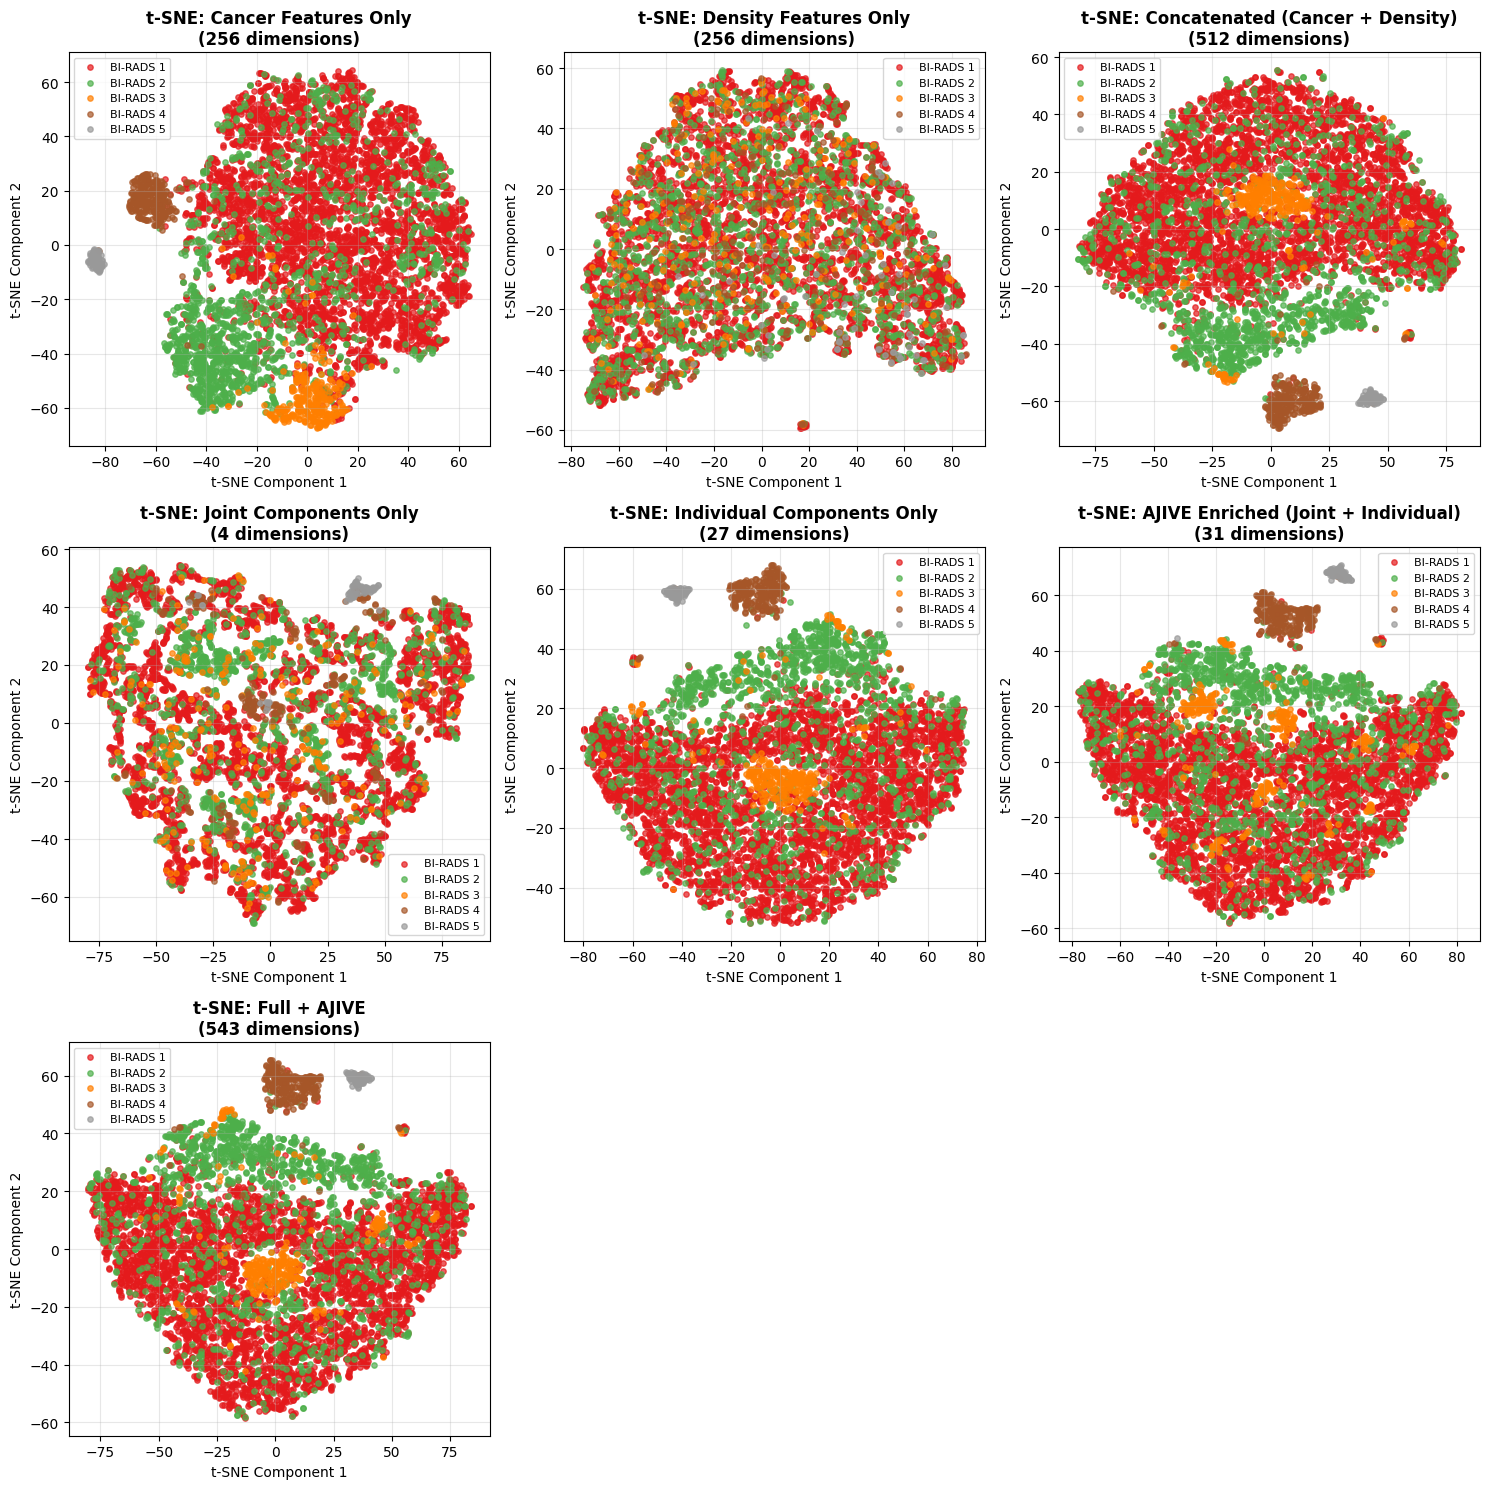

In [ ]:

create_comprehensive_tsne_comparison(
    feature_sets,
    train_cancer_labels,
    split_to_plot='train'
)

Computing t-SNE for Cancer Features Only...
Computing t-SNE for Density Features Only...
Computing t-SNE for Concatenated (Cancer + Density)...
Computing t-SNE for Joint Components Only...
Computing t-SNE for Individual Components Only...
Computing t-SNE for AJIVE Enriched (Joint + Individual)...
Computing t-SNE for Full + AJIVE...


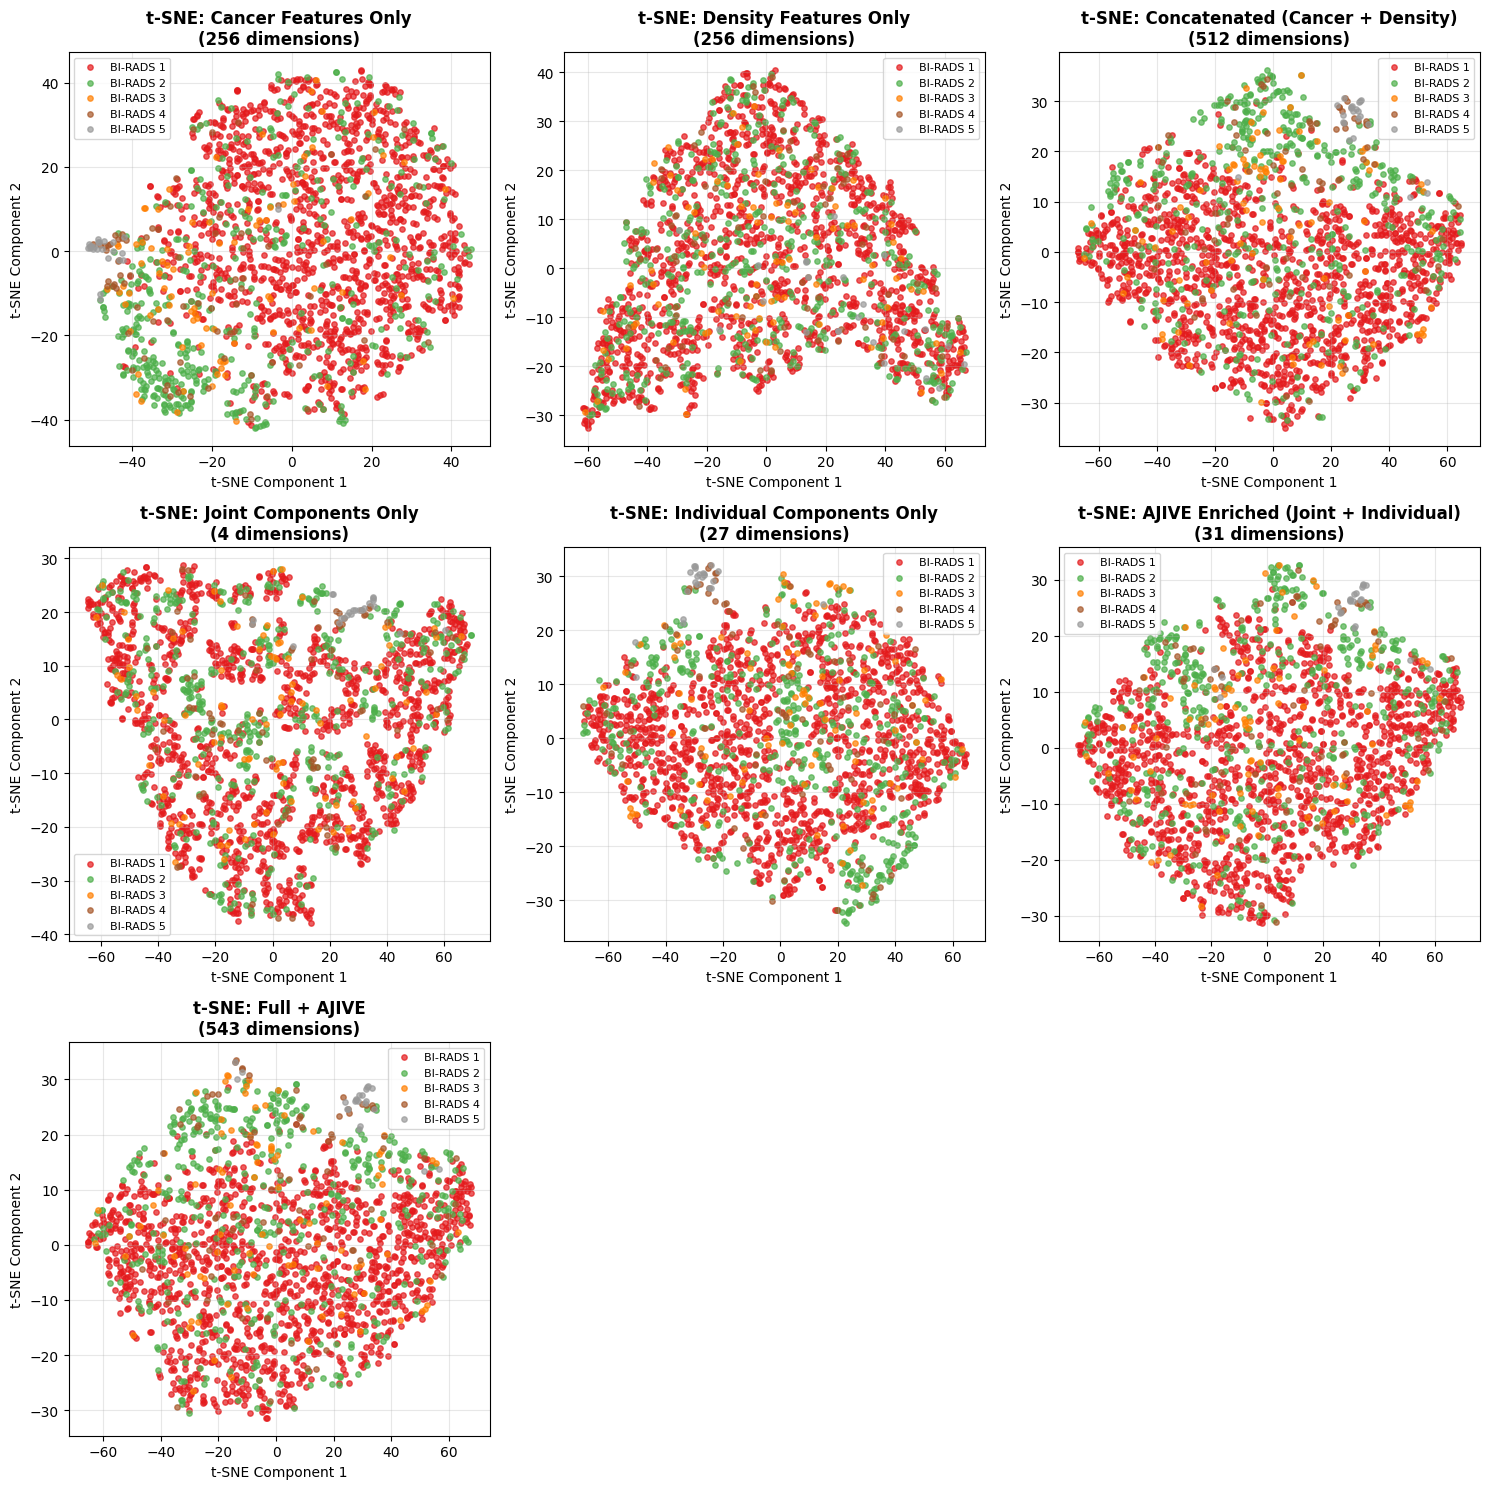

In [21]:
create_comprehensive_tsne_comparison(
    feature_sets,
    test_cancer_labels,
    split_to_plot='test'
)

In [10]:

all_results = compare_feature_transformations_svm_clean(feature_sets, label_sets)

print("\n Final Summary:")
print(f"Total results: {len(all_results)}")
for i, result in enumerate(all_results):
    print(f"  {i+1}. {result['feature_name']}: F1={result['test_f1_macro']:.4f}")

Comparing Feature Transformations with RBF SVM...

[1/7] 🔍 Cancer Features Only
Dimensions: 256
--------------------------------------------------
 Accuracy: 0.4059 | F1: 0.4531

[2/7] 🔍 Density Features Only
Dimensions: 256
--------------------------------------------------
 Accuracy: 0.2004 | F1: 0.1615

[3/7] 🔍 Concatenated (Cancer + Density)
Dimensions: 512
--------------------------------------------------
 Accuracy: 0.4227 | F1: 0.4753

[4/7] 🔍 Joint Components Only
Dimensions: 4
--------------------------------------------------
 Accuracy: 0.4330 | F1: 0.4626

[5/7] 🔍 Individual Components Only
Dimensions: 27
--------------------------------------------------
 Accuracy: 0.4342 | F1: 0.4803

[6/7] 🔍 AJIVE Enriched (Joint + Individual)
Dimensions: 31
--------------------------------------------------
 Accuracy: 0.4336 | F1: 0.4799

[7/7] 🔍 Full + AJIVE
Dimensions: 543
--------------------------------------------------
 Accuracy: 0.4226 | F1: 0.4752

 Execution completed: 7 evaluat

In [18]:
feature_set = ('Cancer individual', aj.view_specific_[0].individual_.transform(train_cancer_features), aj.view_specific_[0].individual_.transform(val_cancer_features), aj.view_specific_[0].individual_.transform(test_cancer_features))
result = compare_feature_transformations_svm_clean([feature_set], label_sets)


Comparing Feature Transformations with RBF SVM...

[1/1] 🔍 Cancer individual
Dimensions: 10
--------------------------------------------------
 Accuracy: 0.4038 | F1: 0.4516

 Execution completed: 1 evaluations


In [19]:
dens_label_set = [train_dens_labels, val_dens_labels, test_dens_labels]
all_results = compare_feature_transformations_svm_clean(feature_sets, dens_label_set)

print("\n Final Summary:")
print(f"Total results: {len(all_results)}")
for i, result in enumerate(all_results):
    print(f"  {i+1}. {result['feature_name']}: F1={result['test_f1_macro']:.4f}")

Comparing Feature Transformations with RBF SVM...

[1/7] 🔍 Cancer Features Only
Dimensions: 256
--------------------------------------------------
 Accuracy: 0.3088 | F1: 0.3248

[2/7] 🔍 Density Features Only
Dimensions: 256
--------------------------------------------------
 Accuracy: 0.5398 | F1: 0.5566

[3/7] 🔍 Concatenated (Cancer + Density)
Dimensions: 512
--------------------------------------------------
 Accuracy: 0.5335 | F1: 0.5511

[4/7] 🔍 Joint Components Only
Dimensions: 4
--------------------------------------------------
 Accuracy: 0.5300 | F1: 0.5508

[5/7] 🔍 Individual Components Only
Dimensions: 27
--------------------------------------------------
 Accuracy: 0.5160 | F1: 0.5395

[6/7] 🔍 AJIVE Enriched (Joint + Individual)
Dimensions: 31
--------------------------------------------------
 Accuracy: 0.5179 | F1: 0.5406

[7/7] 🔍 Full + AJIVE
Dimensions: 543
--------------------------------------------------
 Accuracy: 0.5365 | F1: 0.5534

 Execution completed: 7 evaluat

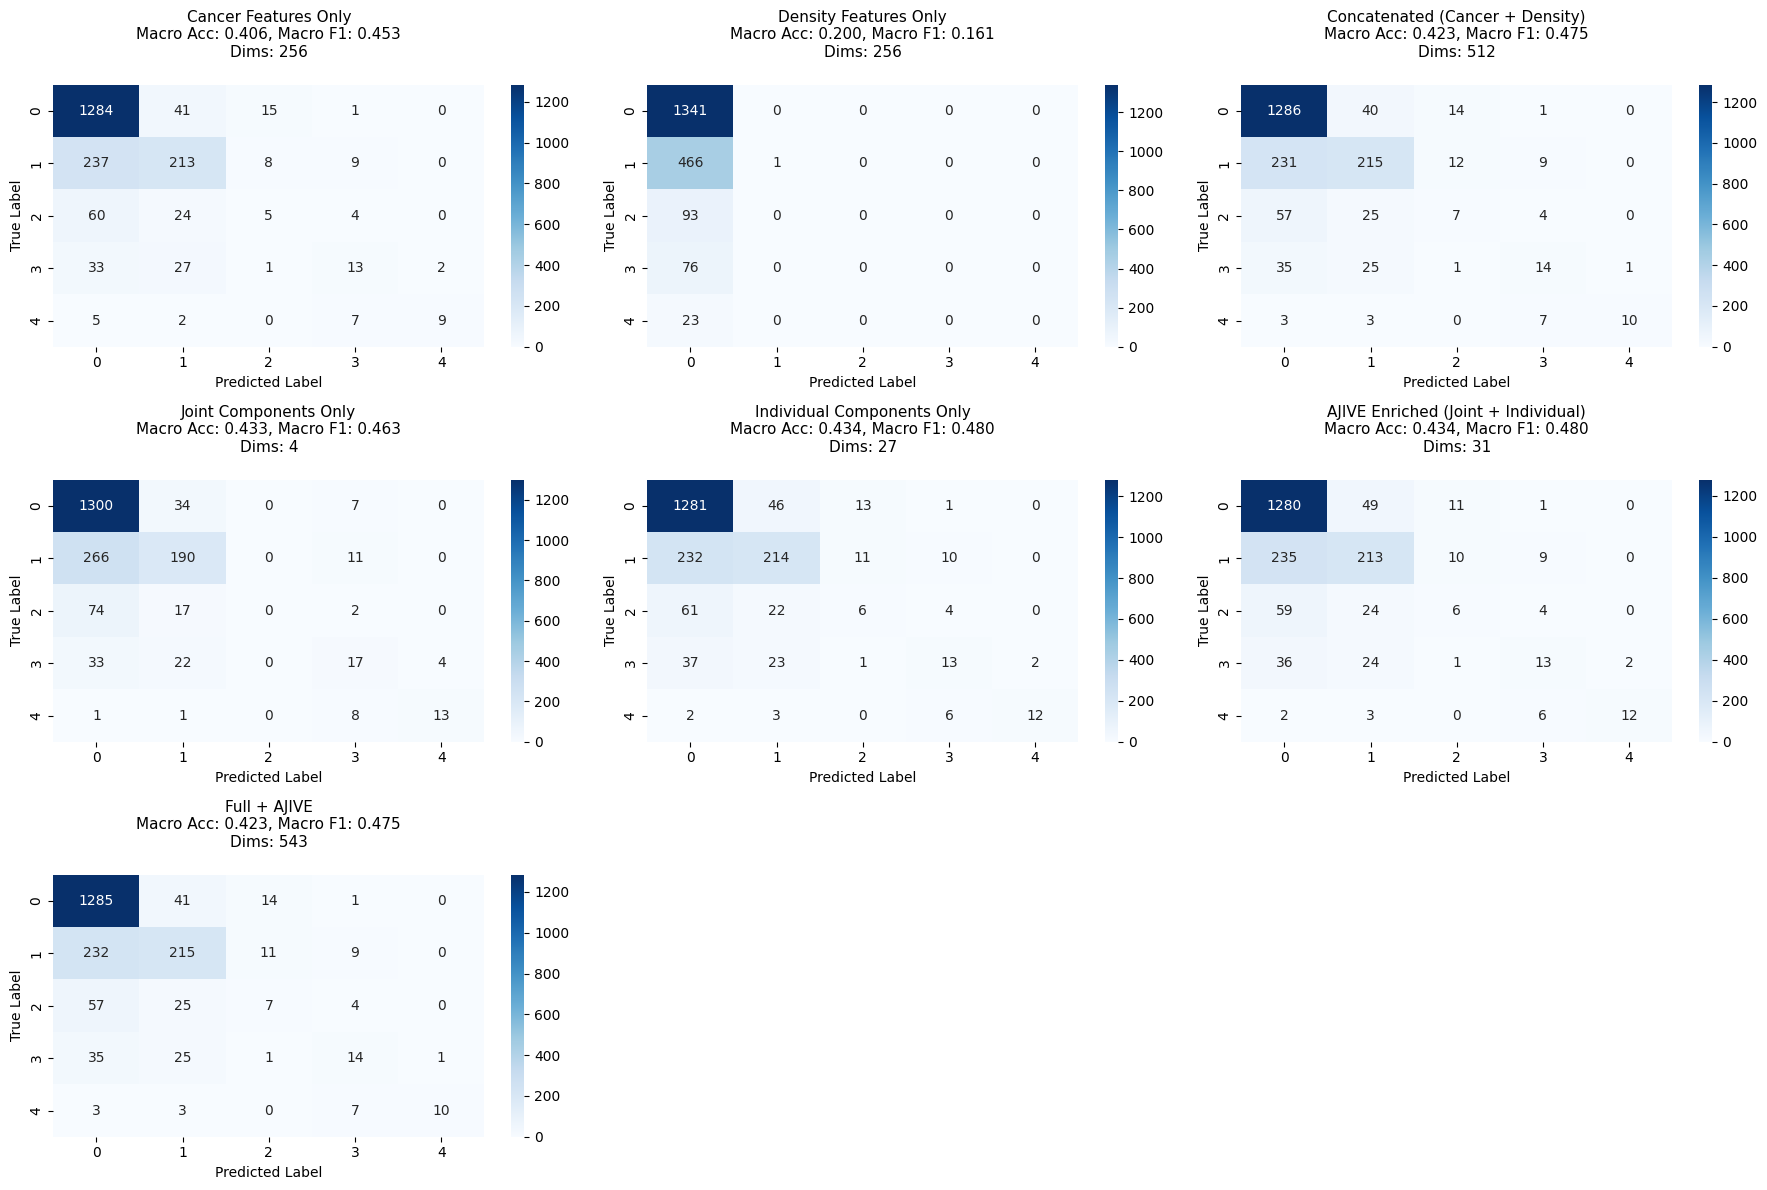

In [13]:

# Create visualizations
confusion_fig = plot_confusion_matrices_comparison(all_results)

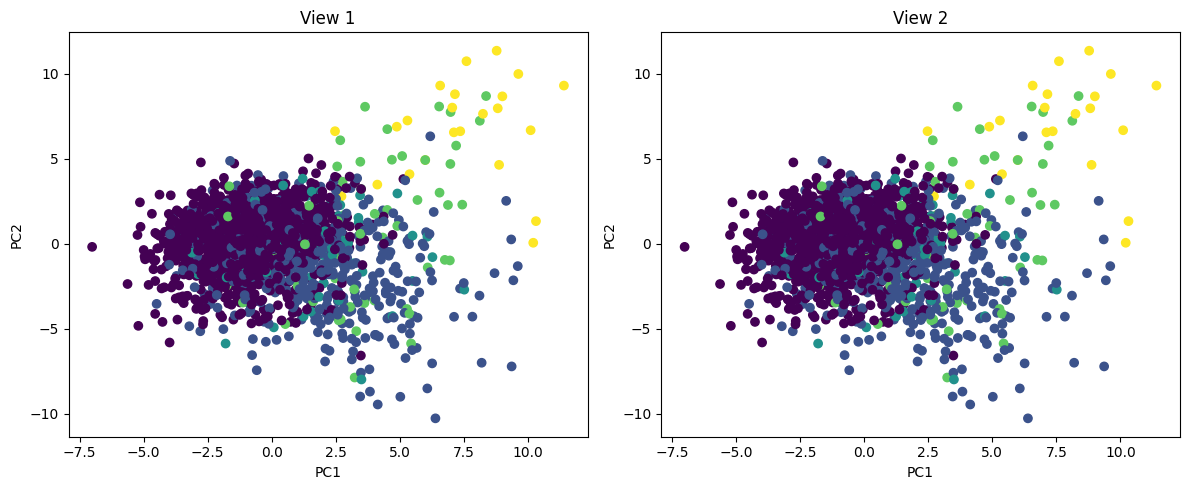

In [21]:
import sklearn
points = aj.view_specific_[0].joint_.transform(test_cancer_features)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    pca = sklearn.decomposition.PCA(n_components=2)
    X_pca = pca.fit_transform(points)
    scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=test_cancer_labels)
    axes[i].set_title(f'View {i+1}')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
plt.tight_layout()
plt.show()

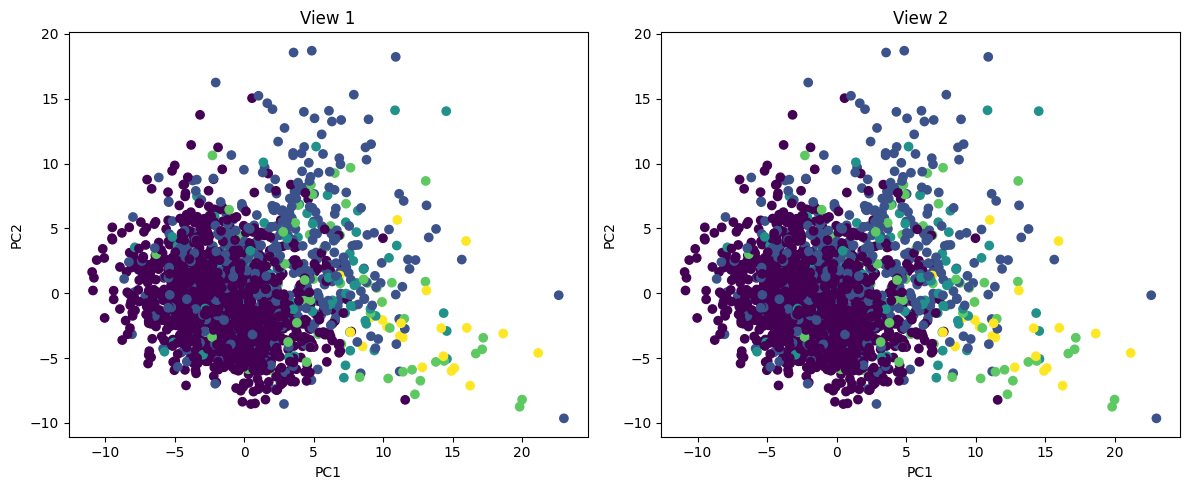

In [22]:
import sklearn
points = aj.view_specific_[0].individual_.transform(test_cancer_features)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    pca = sklearn.decomposition.PCA(n_components=2)
    X_pca = pca.fit_transform(points)
    scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=test_cancer_labels)
    axes[i].set_title(f'View {i+1}')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
plt.tight_layout()
plt.show()